# Project: Speech Emotional Recognition

## Requirements
1. OpenSmile

## 1. Preprocessing input data

### 1.1. Import modules and define the data_path

Import the required modules.

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import matplotlib.pyplot as plt
import math

Assuming all required files are within the "data" directory

In [2]:
data_path = "/work/peiyun/data"

### 1.2. Getting the info_dict of utterance containing its "label" and "values" of the 3 emotion dimensions
3 emotion dimensions: Valence (positive vs. negative), Activation (calm vs. excited), Dominance (passive vs. aggressive)

In [53]:
info_dict = {}    # name: [session, label, dims]: <int, string, float list>
category_count = {}  # storing selected emotions only

# for each session
for session in range(1,6):
    path = os.path.join(data_path, "IEMOCAP", "Session" + str(session), "dialog", "EmoEvaluation")
    
    # for file in the session
    for filename in os.listdir(path):
        
        # only interested in "summary" txt files
        if filename.endswith(".txt"):
            f = open(os.path.join(path, filename), "r")
            for line in f.readlines():
                if line[0] == "[":
                    name, label, dims = line.strip("\n").split("\t")[1:]
                    # convert string to a float list
                    dims = dims[1:-1].split(",")
                    dims = [float(i) for i in dims]
                    # add to info dict
                    info_dict[name] = [session, label, dims]
                    # increment count
                    category_count[label] = category_count.get(label, 0) + 1
            f.close()

### 1.3. Selecting emotions for the experiment

Remove invalid labels: "xxx"

In [54]:
if "xxx" in category_count:
    category_count.pop("xxx")

Compare the average dimension values of each emotion category

In [56]:
avg_dims_dict = {}

for session, label, dims in info_dict.values():
    
    if label not in category_count:  # ignore removed emotions
        continue
    
    # initialise value
    if label not in avg_dims_dict:
        avg_dims_dict[label] = [0.0, 0.0, 0.0]
        
    # 3 dimensions
    for i in range(3):
        avg_dims_dict[label][i] += dims[i]
        
for (label, val_ls) in avg_dims_dict.items():
    avg_dims_dict[label] = np.divide(val_ls, category_count[label])

In [57]:
avg_dims_dict

{'ang': array([1.90571242, 3.63553917, 3.94983354]),
 'dis': array([2.75, 2.  , 1.75]),
 'exc': array([3.94508501, 3.57837012, 3.40257771]),
 'fea': array([2.504165 , 3.241665 , 2.3666675]),
 'fru': array([2.26239367, 3.18487409, 3.32170568]),
 'hap': array([3.95126017, 3.11848773, 2.92380908]),
 'neu': array([2.9713606 , 2.72575193, 2.83055263]),
 'oth': array([3.2778    , 2.61113333, 2.16666667]),
 'sad': array([2.25307463, 2.56349935, 2.82795175]),
 'sur': array([2.84501495, 3.21728972, 2.85436168])}

Function for calculating Euclidean (L2) distance between two dimension lists.

In [58]:
def cal_dist(dim_ls1, dim_ls2):
    dist = 0
    # 3 dimensions
    for i in range(3):
        dist += pow(dim_ls1[i] - dim_ls2[i],2)  # squaring
    dist = math.sqrt(dist)
    return dist

In [59]:
np.set_printoptions(linewidth = np.inf)  # for printing distance matrix

In [60]:
# list of emotions
emo_ls = avg_dims_dict.keys()
num_emo = len(emo_ls)

# initialise distance matrix
dist_matrix = np.zeros((num_emo,num_emo))

for i in range(num_emo):
    for j in range(num_emo):
        if i == j:  # on diagonal
            dist_matrix[i][j] = 0.0
        else:       # off diagonal
            emo1 = emo_ls[i]
            emo2 = emo_ls[j]
            dist_matrix[i][j] = cal_dist(avg_dims_dict[emo1], avg_dims_dict[emo2])

print emo_ls
print dist_matrix / np.amax(dist_matrix)   # print normalised distance matrix

['oth', 'ang', 'exc', 'fea', 'sad', 'sur', 'fru', 'hap', 'neu', 'dis']
[[0.         0.86190377 0.59456076 0.35487401 0.42551637 0.35342757 0.57227358 0.39509107 0.25803767 0.31679616]
 [0.86190377 0.         0.73643115 0.60584133 0.55438677 0.52380539 0.29682865 0.81795534 0.62523396 1.        ]
 [0.59456076 0.73643115 0.         0.62974949 0.71645789 0.44662321 0.60314009 0.23145845 0.49333603 0.89909202]
 [0.35487401 0.60584133 0.62974949 0.         0.29904659 0.20761459 0.34403835 0.54231887 0.29161551 0.49088284]
 [0.42551637 0.55438677 0.71645789 0.29904659 0.         0.30762075 0.27672142 0.62376702 0.25673433 0.4580931 ]
 [0.35342757 0.52380539 0.44662321 0.20761459 0.30762075 0.         0.26064395 0.38797276 0.17713502 0.57398012]
 [0.57227358 0.29682865 0.60314009 0.34403835 0.27672142 0.26064395 0.         0.60536985 0.34064439 0.70696981]
 [0.39509107 0.81795534 0.23145845 0.54231887 0.62376702 0.38797276 0.60536985 0.         0.36948296 0.70351616]
 [0.25803767 0.62523396 0

In [61]:
np.set_printoptions(linewidth = 75)  # back to default value

Only use emotions with at least 100 instances

In [62]:
# only use emotions with at least 100 instances
for emo in category_count.keys():
    if category_count[emo] < 100:
        category_count.pop(emo)

Plot the distribution of each category of emotion (7 categories)

In [63]:
category_count  # 7487 instances

{'ang': 1103,
 'exc': 1041,
 'fru': 1849,
 'hap': 595,
 'neu': 1708,
 'sad': 1084,
 'sur': 107}

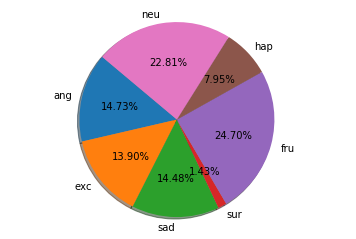

In [64]:
# Data to plot
labels = []
sizes = []

for (label, count) in category_count.items():
    labels.append(label)
    sizes.append(count)
    
# Plot
plt.pie(sizes, labels=labels, autopct='%1.2f%%', 
        shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

### 1.3. Split 7487 files into training and test sets (70% training, 15% test, 15% dev, seed = 100)
(seed = 100 for reproducibility)

In [ ]:
# get filename list and the corresponding label list
filename_ls = []
label_ls = []

for filename in sorted(info_dict.keys()):   # sorted filenames
    session, label, dims = info_dict[filename]
    if label in category_count.keys():  # select files with interested emotions only
        filename_ls.append(filename)
        label_ls.append(label)
        
# splitting into train and test
filename_train, filename_remain, label_train, label_remain = train_test_split(filename_ls, label_ls, 
                                                                              train_size = 0.7, random_state = 100,
                                                                              shuffle = True)

# splitting into train and test
filename_dev, filename_test, label_dev, label_test = train_test_split(filename_remain, label_remain, 
                                                                      test_size = 0.5, random_state = 100,
                                                                      shuffle = True)

### 1.4. Move files into test, dev, and train directories

Copying all input files to input_path. (7487 utterances in total)

In [ ]:
input_path = os.path.join(data_path, "input")  # /work/peiyun/data/input

Create input directory (data_path/input) if not exist.

In [ ]:
if not os.path.exists(input_path):
    os.makedirs(input_path)

Move all required files to input path.

In [ ]:
# for each session
for session in range(1,6):
    path = os.path.join(data_path, "IEMOCAP", "Session" + str(session), "sentences", "wav")
    
    # for each dialog
    for dialog in os.listdir(path):
        dialog_path = os.path.join(path, dialog)
            
        # for each utterance (file)
        for filename in os.listdir(dialog_path):
            if filename.endswith(".wav") and filename[:-4] in filename_ls:  # only move the interested files
                shutil.copy(os.path.join(dialog_path, filename), os.path.join(input_path, filename))

Create test and train directory for input instances if not exist.

In [ ]:
for data_type in ["train", "test", "dev"]:
    path = os.path.join(input_path, data_type)
    if not os.path.exists(path):
        os.makedirs(path)

Moving files to its directory.

In [ ]:
for filename in filename_train:
    shutil.move(os.path.join(input_path, filename + ".wav"), os.path.join(input_path, "train", filename + ".wav"))
    
for filename in filename_test:
    shutil.move(os.path.join(input_path, filename + ".wav"), os.path.join(input_path, "test", filename + ".wav"))
    
for filename in filename_dev:
    shutil.move(os.path.join(input_path, filename + ".wav"), os.path.join(input_path, "dev", filename + ".wav"))

### 1.5. Getting the transcriptions of each utterance

In [ ]:
transcript_dict = {}

# for each session
for session in range(1,6):
    path = os.path.join(data_path, "IEMOCAP", "Session" + str(session), "dialog", "transcriptions")
    
    # for file in the session
    for filename in os.listdir(path):
        
        # only interested in txt files
        if filename.endswith(".txt"):
            f = open(os.path.join(path, filename), "r")
            for line in f.readlines():
                if line.startswith("Ses"):  # utterance name
                    ls = line.strip("\r\n").split()
                    name = ls[0]
                    transcript = " ".join(ls[2:])
                    transcript_dict[name] = transcript
            f.close()

### 1.6. Writing information of each utterance into csv file (5240 train instances, 1124 test instances, 1123 dev instances)

In [ ]:
with open(os.path.join(data_path, "label.csv") , mode='w') as label_file:
    
    writer = csv.writer(label_file, delimiter=",")
    
    for filename in filename_ls:
        session, label, dims = info_dict[filename]
        transcript = transcript_dict[filename]
        data_type = ""
        if filename in filename_train:
            data_type = "train"
        elif filename in filename_test:
            data_type = "test"
        elif filename in filename_dev:
            data_type = "dev"
        writer.writerow([filename, session, label, dims, data_type, transcript])
                
    label_file.close()

## 2. Feature Extraction with openSMILE

File for feature extractions.

In [ ]:
%%file feature.py

# Import the required modules
import argparse
import os
from subprocess import call
import csv
import sys
import numpy as np
from time import gmtime, strftime, time

# Global variables
data_path = "/work/peiyun/data"

# Get the ground_truth label number of the file
def get_label(label_file, filename):
    
    with open(label_file, mode = "r") as f:
        reader = csv.reader(f)
        for row in reader:
            name, session, label, dims, data_type, transcript = row
            if name == filename:
                return label

# Check input and output directories
def check_dirs(args):
    
    # Check input directory (if not exist -> error)
    if not os.path.exists(os.path.join(data_path, args.input_dir)):
        print "Error: input directory not exist"
        return False
    for data_type in ["train", "test", "dev"]:
        path = os.path.join(data_path, args.input_dir, data_type)
        if not (os.path.exists(path)):
            print "Error: input directory missing train or test directories"
            return False
    
    # Check output directory (if not exist -> create one)
    if not os.path.exists(os.path.join(data_path, args.output_dir)):
        os.makedirs(os.path.join(data_path, args.output_dir))
    for data_type in ["train", "test", "dev"]:
        path = os.path.join(data_path, args.output_dir, data_type)
        if not os.path.exists(path):
            os.makedirs(path)
        config_path = os.path.join(path, args.config[:-5])
        if not os.path.exists(config_path):
            os.makedirs(config_path)
    
    return True

# Function for extracting features with openSMILE (Return whether successed)
def extract_features(args):
    if not check_dirs(args):
        return False   # failed to read inputs
            
    # Iterate over wav audio files in input directory
    for data_type in ["train", "test", "dev"]:
        path_in = os.path.join(data_path, args.input_dir, data_type)
        
        for filename in os.listdir(path_in):
            
            # Only interested in wav files
            if filename.endswith(".wav"):
                # in
                file_in = os.path.join(path_in, filename)
                config = os.path.join(data_path, "config", args.config)
                
                filename = filename[:-4]  # [:-4] for removing .wav
                
                # out
                path_out = os.path.join(data_path, args.output_dir, data_type, args.config[:-5])
                csv_out = os.path.join(path_out, filename + "_" + args.config[:-5] + ".csv")
                arff_out = os.path.join(path_out, filename + "_" + args.config[:-5] + ".arff")  # [:-5] for removing .conf
                label = get_label(os.path.join(data_path, args.label), filename)
                
                # use openSMILE
                call(["SMILExtract", "-l", "0", "-noconsoleoutput", "-I", file_in, 
                      "-C", config, "-D", csv_out, "-O", arff_out, "-instname", filename, "-label", label])
                
    return True

# Obtaining args from terminal
def get_args():
    
    parser = argparse.ArgumentParser(description='Extract features for files in the directory using openSMILE')
    
    parser.add_argument("-i",                   # optional argument (no "-" for positional)
                        "--input_dir",   # name of the attribute (dest)
                        action = "store",       # can be "store", "store_const", "store_true", etc.
                        # nargs = N for associating N args with a single action
                        # const = ... to hold constant values
                        # default = ... to set default value
                        type = str,             # check arg type
                        # choice = [.., .., ..] # restrict set of values
                        required = True,        # make an option required
                        # metavar = "XXX" for changing display name
                        help = "The directory of input audio files (wav)")
    
    parser.add_argument("-o", "--output_dir", type = str, required = True, help = "The directory of results")
    parser.add_argument("-c", "--config", type = str, required = True, help = "Configuration filename")
    parser.add_argument("-l", "--label", type = str, required = True, help = "Label filename")
    args = parser.parse_args()
    
    return args

def main():
    # Obtaining terminal args
    args = get_args()
    
    start_time = time()
    
    # Extracting features according to args
    if not extract_features(args):
        print "Failed to extract features"
    else:
        end_time = time()
        print("Time taken for extracting features:", strftime("%H:%M:%S", gmtime(end_time - start_time)))
        print "Successfully extracted features"

# If running the file directly
if __name__ == "__main__":
    main()

Running script for extracting features. 

In [ ]:
%%!
python feature.py -i "input" -o "output" -c "IS09_emotion.conf" -l "label.csv"

In [ ]:
%%!
python feature.py -i "input" -o "output" -c "IS10_paraling.conf" -l "label.csv"